# TP5 — Calcul sur GPU avec PyCUDA

**Auteur :** LIANG Tianyi  
**Cours :** OS02 - Calcul Parallèle et Distribué  
**Date :** Février 2026

---

## Configuration GPU

Avant de commencer :
1. Menu **Exécution** → **Modifier le type d'exécution**
2. Choisir **GPU** comme accélérateur matériel
3. **Enregistrer**

## 0. Vérification du GPU

In [1]:
!nvidia-smi

Tue Feb 17 09:59:13 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Installation de PyCUDA

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2026.1-cp312-cp312-linux_x86_64.whl size=659448 sha256=28acd8d2fcf667f056e62b6d514ada9a209dc20ea466e9a37ceb265059ee8605
  Stored in directory: /root/.cache/pip/wheels/90/2a/71/75ec0cc316cc0ff494bfffa2935e02580129cb7f859a0cfd8f
Successfully built pycuda


## Import des modules PyCUDA

Ces imports ne sont nécessaires qu'**une seule fois** pour toute la session.

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time

## Test de vérification : kernel `doublify`

On crée une matrice 4×4, on la transfère sur le GPU, on double chaque élément, puis on récupère le résultat.

In [4]:
# Création d'une matrice 4x4 avec graine fixe
np.random.seed(1729)
a = np.random.randn(4, 4).astype(np.float32)

# Allocation mémoire GPU
a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)

# Kernel CUDA : doubler chaque élément
mod = SourceModule("""
__global__ void doublify(int dim_x, int dim_y, float *a) {
    if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y)) {
        int idx = threadIdx.x + threadIdx.y * dim_x;
        a[idx] *= 2;
    }
}
""")

func = mod.get_function("doublify")
dim = np.int32(4)
func(dim, dim, a_gpu, block=(4, 4, 1))

# Récupération du résultat
a_doubled = np.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

print("Matrice originale :")
print(a)
print("\nMatrice doublée (GPU) :")
print(a_doubled)
print("\nVérification (2*a == a_doubled) :", np.allclose(2 * a, a_doubled))

Matrice originale :
[[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]

Matrice doublée (GPU) :
[[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]

Vérification (2*a == a_doubled) : True


---

# Exercice 1 : Addition de deux vecteurs

On écrit un kernel CUDA pour additionner deux vecteurs de grande dimension (> 256 éléments).  
**Points clés :**
- L'indice global est calculé via `threadIdx.x + blockIdx.x * blockDim.x`
- La taille de chaque bloc est limitée à 256 threads
- Il faut calculer le nombre de blocs nécessaires : `grid = (N + block_size - 1) // block_size`
- Les arguments entiers doivent être passés comme `numpy.int32`

In [5]:
# Kernel CUDA pour l'addition de deux vecteurs
mod_vec = SourceModule("""
__global__ void vec_add(int n, float *a, float *b, float *c) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}
""")

vec_add = mod_vec.get_function("vec_add")

In [6]:
# Test avec différentes tailles de vecteurs
for N in [256, 1000, 10000, 100000, 1000000]:
    # Données
    a = np.random.randn(N).astype(np.float32)
    b = np.random.randn(N).astype(np.float32)
    c = np.empty_like(a)

    # Allocation GPU
    a_gpu = cuda.mem_alloc(a.nbytes)
    b_gpu = cuda.mem_alloc(b.nbytes)
    c_gpu = cuda.mem_alloc(c.nbytes)

    # Transfert Host → Device
    cuda.memcpy_htod(a_gpu, a)
    cuda.memcpy_htod(b_gpu, b)

    # Configuration des blocs et de la grille
    block_size = 256
    grid_size = (N + block_size - 1) // block_size

    # Exécution du kernel
    vec_add(np.int32(N), a_gpu, b_gpu, c_gpu,
            block=(block_size, 1, 1), grid=(grid_size, 1))

    # Transfert Device → Host
    cuda.memcpy_dtoh(c, c_gpu)

    # Vérification
    c_ref = a + b
    ok = np.allclose(c, c_ref)
    print(f"N = {N:>8d} | blocs = {grid_size:>5d} | correct = {ok}")

    # Libération mémoire
    a_gpu.free()
    b_gpu.free()
    c_gpu.free()

N =      256 | blocs =     1 | correct = True
N =     1000 | blocs =     4 | correct = True
N =    10000 | blocs =    40 | correct = True
N =   100000 | blocs =   391 | correct = True
N =  1000000 | blocs =  3907 | correct = True


### Benchmark : CPU (NumPy) vs GPU (CUDA)

In [7]:
N = 10_000_000
a = np.random.randn(N).astype(np.float32)
b = np.random.randn(N).astype(np.float32)
c = np.empty_like(a)

# --- CPU ---
t_cpu_start = time.time()
for _ in range(100):
    c_cpu = a + b
t_cpu = (time.time() - t_cpu_start) / 100

# --- GPU ---
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

block_size = 256
grid_size = (N + block_size - 1) // block_size

# Warm-up
for _ in range(10):
    vec_add(np.int32(N), a_gpu, b_gpu, c_gpu,
            block=(block_size, 1, 1), grid=(grid_size, 1))

# Chronométrage GPU (kernel seul)
start = cuda.Event()
end = cuda.Event()
start.record()
for _ in range(100):
    vec_add(np.int32(N), a_gpu, b_gpu, c_gpu,
            block=(block_size, 1, 1), grid=(grid_size, 1))
end.record()
end.synchronize()
t_gpu = start.time_till(end) / 100 / 1000  # ms → s

cuda.memcpy_dtoh(c, c_gpu)

print(f"Addition de vecteurs (N = {N:,})")
print(f"  CPU (NumPy)  : {t_cpu*1000:.3f} ms")
print(f"  GPU (kernel) : {t_gpu*1000:.3f} ms")
print(f"  Speedup      : {t_cpu/t_gpu:.2f}×")
print(f"  Correct      : {np.allclose(c, c_cpu)}")

a_gpu.free()
b_gpu.free()
c_gpu.free()

Addition de vecteurs (N = 10,000,000)
  CPU (NumPy)  : 15.460 ms
  GPU (kernel) : 0.460 ms
  Speedup      : 33.64×
  Correct      : True


---

# Exercice 2 : Addition de deux matrices

Adaptation de l'exercice précédent pour des matrices carrées.  
**Points clés :**
- Utilisation de blocs 2D : `block=(block_x, block_y, 1)`
- Grille 2D : `grid=(grid_x, grid_y)`
- Calcul des indices : `col = threadIdx.x + blockIdx.x * blockDim.x` et `row = threadIdx.y + blockIdx.y * blockDim.y`

In [8]:
# Kernel CUDA pour l'addition de deux matrices
mod_mat = SourceModule("""
__global__ void mat_add(int dim_x, int dim_y, float *a, float *b, float *c) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;
    if (col < dim_x && row < dim_y) {
        int idx = col + row * dim_x;
        c[idx] = a[idx] + b[idx];
    }
}
""")

mat_add = mod_mat.get_function("mat_add")

In [9]:
# Test avec différentes tailles de matrices
for dim in [16, 64, 256, 512, 1024, 2048]:
    # Données
    a = np.random.randn(dim, dim).astype(np.float32)
    b = np.random.randn(dim, dim).astype(np.float32)
    c = np.empty_like(a)

    # Allocation GPU
    a_gpu = cuda.mem_alloc(a.nbytes)
    b_gpu = cuda.mem_alloc(b.nbytes)
    c_gpu = cuda.mem_alloc(c.nbytes)

    cuda.memcpy_htod(a_gpu, a)
    cuda.memcpy_htod(b_gpu, b)

    # Configuration des blocs 2D et de la grille
    block_x = 16
    block_y = 16
    grid_x = (dim + block_x - 1) // block_x
    grid_y = (dim + block_y - 1) // block_y

    # Exécution du kernel
    mat_add(np.int32(dim), np.int32(dim), a_gpu, b_gpu, c_gpu,
            block=(block_x, block_y, 1), grid=(grid_x, grid_y))

    # Résultat
    cuda.memcpy_dtoh(c, c_gpu)

    # Vérification
    ok = np.allclose(c, a + b)
    print(f"Matrice {dim:>5d}×{dim:<5d} | grid = ({grid_x:>4d},{grid_y:>4d}) | correct = {ok}")

    a_gpu.free()
    b_gpu.free()
    c_gpu.free()

Matrice    16×16    | grid = (   1,   1) | correct = True
Matrice    64×64    | grid = (   4,   4) | correct = True
Matrice   256×256   | grid = (  16,  16) | correct = True
Matrice   512×512   | grid = (  32,  32) | correct = True
Matrice  1024×1024  | grid = (  64,  64) | correct = True
Matrice  2048×2048  | grid = ( 128, 128) | correct = True


---

# Exercice 3 : Ensemble de Mandelbrot sur GPU

On transforme le calcul de l'ensemble de Mandelbrot pour que **chaque thread GPU calcule un pixel**.

Rappel : pour chaque point $c = c_r + i \cdot c_i$ du plan complexe, on itère $z_{n+1} = z_n^2 + c$ et on vérifie si $|z| > 2$ (divergence).

### Version CPU (NumPy) — référence

/tmp/ipython-input-999699976.py:15: RuntimeWarning: overflow encountered in square
  z = z**2 + c
/tmp/ipython-input-999699976.py:15: RuntimeWarning: invalid value encountered in square
  z = z**2 + c


Temps CPU (NumPy) : 0.8779s


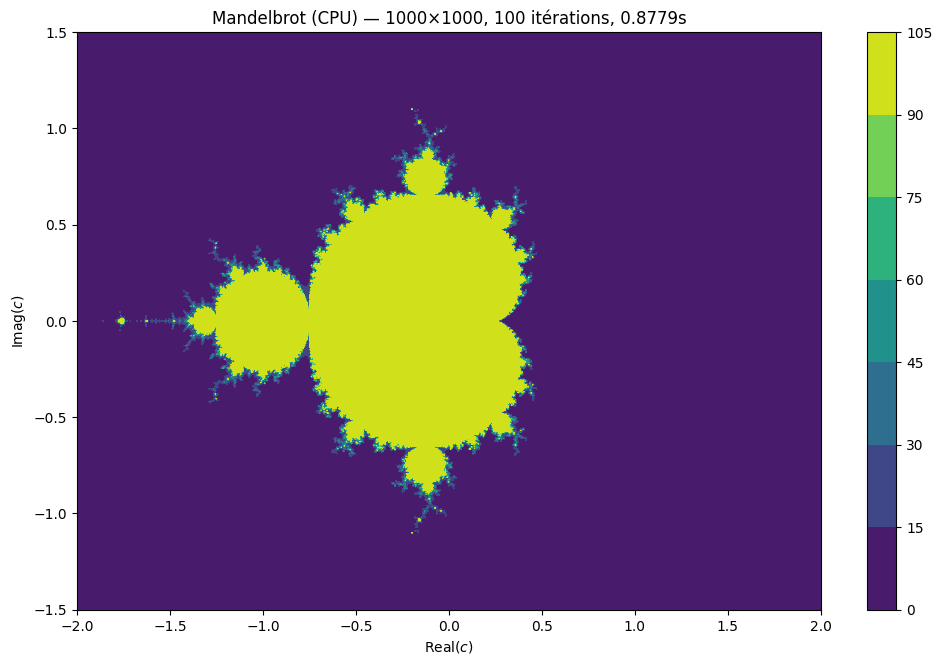

In [10]:
import pylab as plt

# Paramètres
loop = 100   # nombre d'itérations
div = 1000   # résolution (div × div)

# Tous les valeurs possibles de c
c = np.linspace(-2, 2, div)[:, np.newaxis] + 1j * np.linspace(-1.5, 1.5, div)[np.newaxis, :]
ones = np.ones(np.shape(c), np.int32)
color_cpu = ones * (loop + 5)

t_cpu_start = time.time()
z = 0
for n in range(0, loop):
    z = z**2 + c
    diverged = np.abs(z) > 2
    color_cpu[diverged] = np.minimum(color_cpu[diverged], ones[diverged] * n)
t_cpu_elapsed = time.time() - t_cpu_start

print(f"Temps CPU (NumPy) : {t_cpu_elapsed:.4f}s")

# Affichage
plt.figure(figsize=(12, 7.5))
plt.contourf(c.real, c.imag, color_cpu)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.title(f"Mandelbrot (CPU) — {div}×{div}, {loop} itérations, {t_cpu_elapsed:.4f}s")
plt.xlim(-2, 2)
plt.ylim(-1.5, 1.5)
plt.colorbar()
plt.show()

### Version GPU (PyCUDA)

Chaque thread calcule un pixel de l'image. Le kernel travaille avec des `float` (simple précision) pour la performance.

In [11]:
# Kernel CUDA pour le calcul de Mandelbrot
mod_mandelbrot = SourceModule("""
__global__ void mandelbrot_kernel(int div, int loop,
                                  float x_min, float x_max,
                                  float y_min, float y_max,
                                  int *color) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;

    if (col >= div || row >= div) return;

    // Coordonnées dans le plan complexe
    float cr = x_min + col * (x_max - x_min) / (float)div;
    float ci = y_min + row * (y_max - y_min) / (float)div;

    // Itération z = z² + c
    float zr = 0.0f, zi = 0.0f;
    int n;
    for (n = 0; n < loop; n++) {
        float zr2 = zr * zr - zi * zi + cr;
        float zi2 = 2.0f * zr * zi + ci;
        zr = zr2;
        zi = zi2;
        if (zr * zr + zi * zi > 4.0f) break;
    }

    int idx = col + row * div;
    color[idx] = (n < loop) ? n : loop + 5;
}
""")

mandelbrot_kernel = mod_mandelbrot.get_function("mandelbrot_kernel")

In [12]:
# Paramètres identiques
loop = 100
div = 1000
x_min, x_max = -2.0, 2.0
y_min, y_max = -1.5, 1.5

# Allocation mémoire GPU pour le résultat
color_gpu_arr = np.zeros((div, div), dtype=np.int32)
color_gpu_mem = cuda.mem_alloc(color_gpu_arr.nbytes)

# Configuration des blocs et de la grille
block_x = 16
block_y = 16
grid_x = (div + block_x - 1) // block_x
grid_y = (div + block_y - 1) // block_y

# Warm-up
mandelbrot_kernel(np.int32(div), np.int32(loop),
                  np.float32(x_min), np.float32(x_max),
                  np.float32(y_min), np.float32(y_max),
                  color_gpu_mem,
                  block=(block_x, block_y, 1), grid=(grid_x, grid_y))

# Chronométrage GPU (avec CUDA Events pour mesure précise)
start_event = cuda.Event()
end_event = cuda.Event()

n_runs = 10
start_event.record()
for _ in range(n_runs):
    mandelbrot_kernel(np.int32(div), np.int32(loop),
                      np.float32(x_min), np.float32(x_max),
                      np.float32(y_min), np.float32(y_max),
                      color_gpu_mem,
                      block=(block_x, block_y, 1), grid=(grid_x, grid_y))
end_event.record()
end_event.synchronize()
t_gpu_elapsed = start_event.time_till(end_event) / n_runs / 1000  # ms → s

# Récupération du résultat
cuda.memcpy_dtoh(color_gpu_arr, color_gpu_mem)

print(f"Temps GPU (CUDA) : {t_gpu_elapsed*1000:.3f} ms")
print(f"Temps CPU (NumPy) : {t_cpu_elapsed*1000:.3f} ms")
print(f"Speedup GPU/CPU   : {t_cpu_elapsed/t_gpu_elapsed:.1f}×")

color_gpu_mem.free()

Temps GPU (CUDA) : 0.168 ms
Temps CPU (NumPy) : 877.880 ms
Speedup GPU/CPU   : 5235.0×


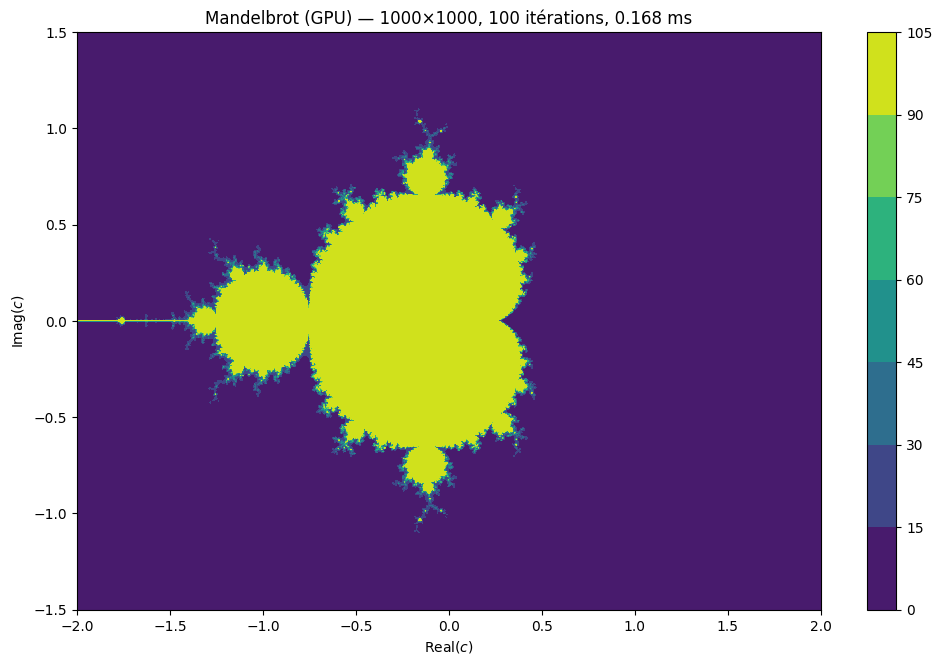

In [13]:
# Affichage du résultat GPU
x = np.linspace(x_min, x_max, div)
y = np.linspace(y_min, y_max, div)

plt.figure(figsize=(12, 7.5))
plt.contourf(x, y, color_gpu_arr)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.title(f"Mandelbrot (GPU) — {div}×{div}, {loop} itérations, {t_gpu_elapsed*1000:.3f} ms")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar()
plt.show()

### Haute résolution : comparaison CPU vs GPU

On augmente la résolution et le nombre d'itérations pour mieux voir l'écart de performance.

In [14]:
# Benchmark sur plusieurs résolutions
print(f"{'Résolution':>12s} | {'Itérations':>10s} | {'CPU (ms)':>10s} | {'GPU (ms)':>10s} | {'Speedup':>8s}")
print("-" * 65)

for div_test in [500, 1000, 2000, 4000]:
    loop_test = 200

    # --- CPU ---
    c_test = np.linspace(-2, 2, div_test)[:, np.newaxis] + 1j * np.linspace(-1.5, 1.5, div_test)[np.newaxis, :]
    ones_test = np.ones(np.shape(c_test), np.int32)
    color_test = ones_test * (loop_test + 5)
    z_test = 0
    t1 = time.time()
    for n in range(loop_test):
        z_test = z_test**2 + c_test
        diverged = np.abs(z_test) > 2
        color_test[diverged] = np.minimum(color_test[diverged], ones_test[diverged] * n)
    t_cpu_ms = (time.time() - t1) * 1000

    # --- GPU ---
    color_gpu_test = np.zeros((div_test, div_test), dtype=np.int32)
    color_gpu_test_mem = cuda.mem_alloc(color_gpu_test.nbytes)
    bx, by = 16, 16
    gx = (div_test + bx - 1) // bx
    gy = (div_test + by - 1) // by

    # Warm-up
    mandelbrot_kernel(np.int32(div_test), np.int32(loop_test),
                      np.float32(-2.0), np.float32(2.0),
                      np.float32(-1.5), np.float32(1.5),
                      color_gpu_test_mem,
                      block=(bx, by, 1), grid=(gx, gy))

    se = cuda.Event()
    ee = cuda.Event()
    se.record()
    n_runs = 5
    for _ in range(n_runs):
        mandelbrot_kernel(np.int32(div_test), np.int32(loop_test),
                          np.float32(-2.0), np.float32(2.0),
                          np.float32(-1.5), np.float32(1.5),
                          color_gpu_test_mem,
                          block=(bx, by, 1), grid=(gx, gy))
    ee.record()
    ee.synchronize()
    t_gpu_ms = se.time_till(ee) / n_runs

    speedup = t_cpu_ms / t_gpu_ms
    print(f"{div_test:>5d}×{div_test:<5d} | {loop_test:>10d} | {t_cpu_ms:>10.1f} | {t_gpu_ms:>10.2f} | {speedup:>7.1f}×")

    color_gpu_test_mem.free()

  Résolution | Itérations |   CPU (ms) |   GPU (ms) |  Speedup
-----------------------------------------------------------------


/tmp/ipython-input-498802857.py:15: RuntimeWarning: overflow encountered in square
  z_test = z_test**2 + c_test
/tmp/ipython-input-498802857.py:15: RuntimeWarning: invalid value encountered in square
  z_test = z_test**2 + c_test


  500×500   |        200 |      299.3 |       0.08 |  3611.7×
 1000×1000  |        200 |     2386.0 |       0.24 | 10043.0×
 2000×2000  |        200 |     9783.3 |       0.85 | 11572.6×
 4000×4000  |        200 |    44216.9 |       3.28 | 13496.9×


---

# Conclusion

- **Exercice 1** : L'addition de vecteurs sur GPU nécessite l'utilisation de `blockIdx` et `blockDim` pour gérer des vecteurs de taille supérieure à la limite de threads par bloc (256/1024).

- **Exercice 2** : L'extension aux matrices utilise des blocs et grilles 2D. Le calcul d'indices devient `col + row * dim_x`.

- **Exercice 3** : Le calcul de Mandelbrot est une tâche **embarrassingly parallel** : chaque pixel est indépendant. Le GPU donne un speedup significatif, d'autant plus grand que la résolution et le nombre d'itérations augmentent.

**Point essentiel** : le GPU excelle pour les calculs massivement parallèles (même opération appliquée à de nombreuses données — paradigme SIMT). Le surcoût de transfert mémoire (Host ↔ Device) est amorti lorsque le volume de calcul est suffisant.